<a href="https://colab.research.google.com/github/kashindra-mahato/SOC-support-system/blob/kashindra/authlog_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [522]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Imports

In [523]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial import distance
import matplotlib.pyplot as plt
import pickle

##Parser for auth

In [524]:
def authParser(log_file):
  file_name = log_file
  file = open(file_name, "r")
  data = []
  order = ["date", "time", "ip", "process", "event"]
  
  for line in file.readlines():
    split1 = re.split(":", line, 3)
    event = split1[3]
    date = re.findall("^\S+\s+[0-9]{2}", line)
    time = re.findall("([0-9]{2}\\:[0-9]{2}\\:[0-9]{2})", line)[0]
    ip = re.findall("([a-z]{2}\\-[0-9]*\\-[0-9]*\\-[0-9]*\\-[0-9]*)", line)[0]
    process = re.findall("([a-zA-Z]*\\[[0-9]*\\])", line)[0]
    details = [date, time, ip, process, event]
    structure = {key:value for key, value in zip(order, details)}
    data.append(structure)
  return data

##parser for single line(string)

In [525]:
def authParserLine(line):
  order = ["date", "time", "ip", "process", "event"]
  
  split1 = re.split(":", line, 3)
  event = split1[3]
  date = re.findall("^\S+\s+[0-9]{2}", line)
  time = re.findall("([0-9]{2}\\:[0-9]{2}\\:[0-9]{2})", line)[0]
  ip = re.findall("([a-z]{2}\\-[0-9]*\\-[0-9]*\\-[0-9]*\\-[0-9]*)", line)[0]
  process = re.findall("([a-zA-Z]*\\[[0-9]*\\])", line)[0]
  details = [date, time, ip, process, event]
  structure = {key:value for key, value in zip(order, details)}
  
  return structure

##function for Cleaning

In [526]:
def clean(dataframe, column_name):
  dataframe[column_name] = dataframe[column_name].str.lower()
  # Remove numbers and special-characters from Event
  dataframe[column_name] = dataframe[column_name].str.replace('\d+', '')
  dataframe[column_name] = dataframe[column_name].str.replace(r'[^\w\s]+', '')
  # remove after 'user' including user :(
  dataframe[column_name] = dataframe[column_name].apply(lambda x: x.split(' user ')[0])
  return dataframe

##Stop word remover

In [527]:
def remStopWord(dataframe, column_name, s_words):
  import nltk
  from nltk.corpus import stopwords
  nltk.download('stopwords')
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(s_words)
  dataframe[column_name] = dataframe[column_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))
  return dataframe

##Tokenizer

In [528]:
def authToken(input_data):
  return list(set(str(input_data).split(' ')))

##Vectorizer

In [529]:
def authVectorizer(input_data):
  vectorizer = TfidfVectorizer(tokenizer=authToken)
  vectorizer.fit(input_data)
  vector_op = vectorizer.transform(input_data)
  return vector_op, vectorizer

##principle component analyzer

In [530]:
def pca(input_data):
  pca = PCA(n_components=0.95) 
  pca.fit(input_data)
  data = pca.transform(input_data)
  return data, pca

##kmeans clustering(training) model

In [531]:
def train(input_data):
  model = KMeans(7)
  model.fit(input_data)
  data = model.transform(input_data)
  return data, model

##function to calculate distance between each instance and their respective centroids

In [532]:
def fromCentDistance(pca_data, model):
  centroids = model.cluster_centers_
  df_cent = pd.DataFrame(centroids)
  df_cent['label'] = [i for i in range(len(centroids))]
  df_pca_data = pd.DataFrame(pca_data)
  df_pca_data['label'] = model.predict(pca_data)
  df_pca_data_join = df_pca_data.join(df_cent, 
                                      on='label', 
                                      how='left', 
                                      lsuffix='_pca',
                                      rsuffix='_cent')
  df_pca_1 = df_pca_data_join.loc[:, "0_pca":"label_pca"]
  df_pca_1.drop('label_pca', axis=1, inplace=True)
  df_cent_1 = df_pca_data_join.loc[:, "0_cent":"label_cent"]
  df_cent_1.drop('label_cent', axis=1, inplace=True)
  list1 = df_pca_1.to_numpy().tolist()
  list2 = df_cent_1.to_numpy().tolist()
  distances = []
  for i in range(len(list1)):
    dist = distance.euclidean(list1[i],list2[i])
    distances.append(dist)
  
  return distances

##function to calculate modified_score

In [533]:
def modified_zscore(distance, consistency_correction=1.4826):
    
    median = np.median(distance)
    
    deviation_from_med = np.array(distance) - median
    
    mad = np.mean(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    
    return mod_zscore, mad

##function to plot anomalies(z>3)

In [534]:
def plot_anomaly(data, threshold):
    data = data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(data), len(data))
    mask_outliers = (data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], data[~mask_outliers],'o', color='b', label='normal')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. Log Event', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Event')
    plt.ylabel('Modified z-score')
    plt.show()

#Training

In [535]:
log = "/content/drive/MyDrive/Colab Notebooks/DATASET/auth.log"

In [536]:
data = authParser(log)

In [537]:
df = pd.DataFrame(data)

In [538]:
df_copy = df.copy()

In [539]:
df_clean = clean(df,"event")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [540]:
stopwords = ['pam_unixcronsession' 'by', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth']

In [541]:
df_clean = remStopWord(df_clean, "event", stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [542]:
path = '/content/drive/MyDrive/Colab Notebooks/models/'

In [543]:
vector_op, vectorizer = authVectorizer(df_clean['event'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [544]:
pickle.dump(vectorizer, open(path + 'auth_vectorizer.sav', 'wb'))

In [545]:
pca_data, pca = pca(vector_op.todense())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [546]:
pickle.dump(pca, open(path + 'auth_pca.sav', 'wb'))

In [547]:
model_data, model = train(pca_data)

In [548]:
pickle.dump(model, open(path + 'auth_model.sav', 'wb'))

In [549]:
distance = fromCentDistance(pca_data, model)

In [550]:
df_copy['distance'] = distance

In [551]:
mod_zscore, mad = modified_zscore(df_copy['distance'])

In [552]:
df_copy['mod_zscore'] = mod_zscore.tolist()

#Output

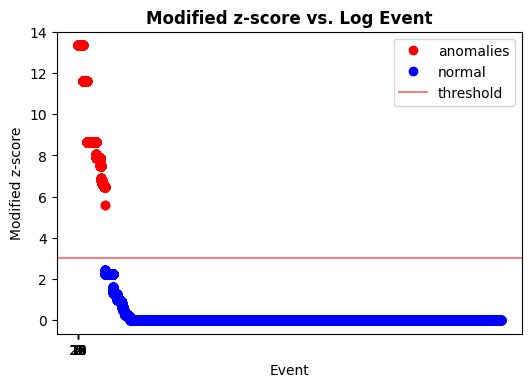

In [553]:
plot_anomaly(df_copy['mod_zscore'],3)

In [ ]:
df.loc[df_copy.mod_zscore>3].event.unique()

In [ ]:
df_copy.loc[df_copy.mod_zscore>3].event.unique()

#Testing

In [556]:
input = "Nov 30 09:22:03 ip-172-31-27-153 sshd[22218]: Did not receive identification string from 196.200.90.236"

In [557]:
data1 = authParserLine(input)

In [558]:
df1 = pd.DataFrame(data1)

In [559]:
df1_copy = df1.copy()

In [560]:
df1_clean = clean(df1,"event")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [561]:
stopwords1 = ['pam_unixcronsession' 'by', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth']

In [562]:
df1_clean = remStopWord(df1_clean, "event", stopwords1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [563]:
loaded_vectorizer = pickle.load(open(path + 'auth_vectorizer.sav', 'rb'))

In [565]:
vector_op1 = loaded_vectorizer.transform(df1_clean['event'])

In [566]:
loaded_pca = pickle.load(open(path + 'auth_pca.sav', 'rb'))

In [ ]:
pca_data1 = loaded_pca.transform(vector_op1.todense())

In [573]:
pca_data1

array([[ 2.91715370e-01,  4.19399885e-01,  3.09503096e-14,
        -1.37348757e-01,  3.19870657e-02,  9.86573913e-02,
         4.42114204e-01,  9.17158171e-01]])

In [569]:
loaded_model = pickle.load(open(path + 'auth_model.sav', 'rb'))

In [570]:
model_data1 = loaded_model.predict(pca_data1)

In [571]:
model_data1

array([5], dtype=int32)

In [572]:
distance1 = fromCentDistance(pca_data1, loaded_model)

AttributeError: ignored

In [ ]:
df1_copy['distance'] = distance1

In [ ]:
mod_zscore1, mad1 = modified_zscore(df1_copy['distance'])

In [ ]:
df1_copy['mod_zscore'] = mod_zscore1.tolist()